# Phase D Demo – Soft Bail-out (ON/OFF)

This notebook demonstrates Phase D repair mechanism with ON/OFF comparison.

Expected signature
- ON buys time (delayed collapse) without optimization.
- Potentially higher cascade depth/breadth (fragility increase).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from capitalmarket.capitalselector.channels import GaussianExplorer, TailRiskExplorer
from capitalmarket.capitalselector.broker import Broker, BrokerConfig
from capitalmarket.capitalselector.builder import CapitalSelectorBuilder
from capitalmarket.capitalselector.repair import RepairContext, RepairPolicySet, CapsPolicy, LagPolicy, SoftBailoutPolicy, IsolationPolicy
from capitalmarket.capitalselector.telemetry import TelemetryLogger


def run(channels, repair: RepairPolicySet, steps=200, seed=1, tau_node=-1.0, logger: TelemetryLogger | None = None):
    ids = list(channels.keys())
    sel = CapitalSelectorBuilder().with_K(len(ids)).with_initial_wealth(0.0).with_rebirth_threshold(-1e9).build()
    broker = Broker(BrokerConfig())
    ctx = RepairContext(wealth={eid: 0.0 for eid in ids})

    # Telemetry REPAIR_ON
    if logger is not None and repair.enabled and repair.bailout and repair.bailout.enabled:
        logger.log(0, "REPAIR_ON", subject_id="bailout", params=repr(repair.bailout))

    rows = []
    peak_time = 0
    peak = -1
    in_cascade = False
    c_depth = 0
    c_breadth = 0

    for t in range(steps):
        sel.channels = [None] * len(ids)
        sel.K = len(ids)
        if sel.w is None or len(sel.w) != len(ids):
            sel.w = np.ones(len(ids)) / len(ids)
        w_raw = sel.allocate()
        raw = {eid: float(w_raw[i]) for i, eid in enumerate(ids)}
        broker.decide_limits()
        w_lim = broker.apply_policies(raw)
        w_full = {eid: float(w_lim.get(eid, 0.0)) for eid in ids}
        w = repair.apply_weights(w_full, t=t, context=ctx)

        step_coll = 0
        r_vec = np.zeros(len(ids))
        c_total = 0.0
        for i, eid in enumerate(ids):
            wi = float(w.get(eid, 0.0))
            if wi <= 0:
                continue
            r, c, alive, dt = channels[eid].step(wi)
            r2, c2, alive2, dt2 = repair.apply_observation((r, c, alive, dt), t=t, explorer_id=eid, context=ctx)
            broker.observe(eid, r2, c2, alive2, dt2)
            broker.mark_funded(eid)
            ctx.wealth[eid] += (r2 - c2)
            if ctx.wealth[eid] < tau_node:
                step_coll += 1
                if logger is not None:
                    logger.log(t, "NODE_COLLAPSE", subject_id=str(eid), wealth=float(ctx.wealth[eid]))
            r_vec[i] = r
            c_total += c
        sel.feedback_vector(r_vec, c_total)

        # Bailout triggers
        if logger is not None and repair.bailout and repair.bailout.enabled:
            for eid in ids:
                last_t = ctx.last_bailout_t.get(eid, -10**9)
                if last_t == t:
                    logger.log(t, "BAILOUT_TRIGGER", subject_id=str(eid), min_funding=float(repair.bailout.min_funding), threshold=float(repair.bailout.threshold))

        if step_coll > 0:
            if not in_cascade and logger is not None:
                logger.log(t, "CASCADE_START", subject_id="global")
            in_cascade = True
            c_depth += 1
            c_breadth = max(c_breadth, step_coll)
        else:
            if in_cascade and logger is not None:
                logger.log(t, "CASCADE_END", subject_id="global", depth=int(c_depth), breadth=int(c_breadth))
            in_cascade = False
            c_depth = 0
            c_breadth = 0

        if step_coll > peak:
            peak = step_coll
            peak_time = t
        rows.append({"t": t, "selector_wealth": float(sel.wealth), "collapses": step_coll, **{f"w_{eid}": float(w.get(eid, 0.0)) for eid in ids}})
    df = pd.DataFrame(rows)
    return df, peak_time


def plot_compare(df_off, df_on, title, save_path: Path | None = None):
    fig, ax = plt.subplots()
    ax.plot(df_off["t"], df_off["collapses"], label="OFF collapses/step")
    ax.plot(df_on["t"], df_on["collapses"], label="ON collapses/step")
    ax.set_title(title)
    ax.set_xlabel("t")
    ax.set_ylabel("collapses per step")
    ax.legend()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path.with_name(save_path.stem + "_collapses.png"), dpi=150, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(df_off["t"], df_off["selector_wealth"], label="OFF selector wealth")
    ax.plot(df_on["t"], df_on["selector_wealth"], label="ON selector wealth")
    ax.set_title(title + " – selector wealth")
    ax.set_xlabel("t")
    ax.set_ylabel("wealth")
    ax.legend()
    if save_path is not None:
        fig.savefig(save_path.with_name(save_path.stem + "_wealth.png"), dpi=150, bbox_inches="tight")
    plt.show()


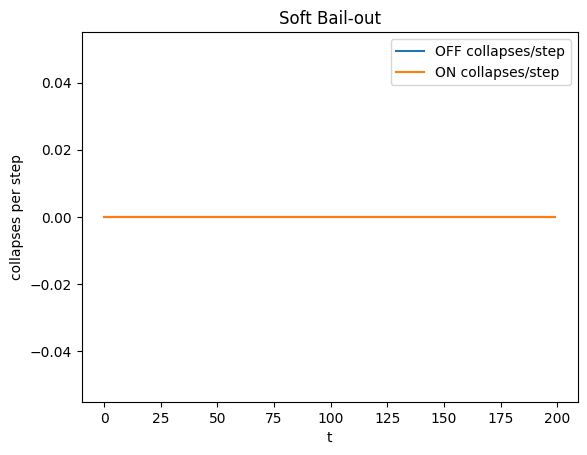

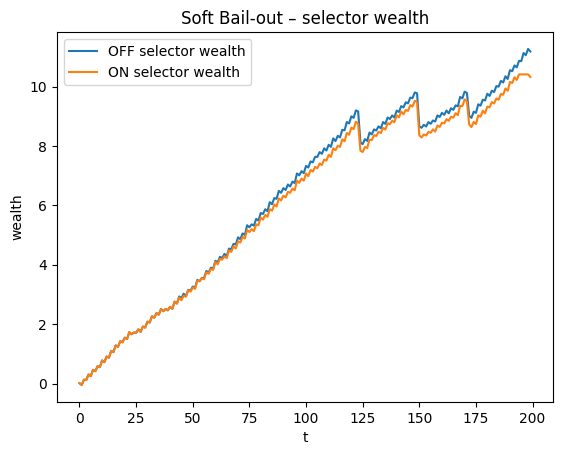

In [ ]:
def make(seed):
    return {
        "stable_neg": GaussianExplorer(mu=-0.05, sigma=0.02, seed=seed+1),
        "volatile_pos": TailRiskExplorer(mu=0.20, sigma=0.05, p_tail=0.05, mu_tail=-1.0, sigma_tail=0.1, seed=seed+2),
    }

repair_off = RepairPolicySet(enabled=False)
repair_on = RepairPolicySet(enabled=True, bailout=SoftBailoutPolicy(enabled=True, min_funding=0.15, threshold=-1.0, cooldown=5))

from pathlib import Path
logs_dir = Path("../logs")
log_off = TelemetryLogger(path=logs_dir / "phase_d_bailout_off_seed1.jsonl")
log_on = TelemetryLogger(path=logs_dir / "phase_d_bailout_on_seed1.jsonl")

df_off, _ = run(make(1), repair_off, steps=200, seed=1, tau_node=-20.0, logger=log_off)
df_on, _ = run(make(1), repair_on, steps=200, seed=1, tau_node=-20.0, logger=log_on)

plot_compare(df_off, df_on, "Soft Bail-out", save_path=Path("../plots/phase_d_bailout_compare.png"))

log_off.close(); log_on.close()
